In [1]:
import posixpath
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np
from shapely.geometry import Polygon
from shapely import plotting
import matplotlib.pyplot as plt
import datetime

## Load datasets and count glaciers

In [2]:
data_root = "D:/OneDrive/Documents/Cours/4A/SFE/data/"

kh_fronts = gpd.read_file(posixpath.join(data_root, "KH-5_ARGON_fronts/KH-5_ARGON_fronts.shp")).to_crs(epsg=25833)
kh_fronts.head()

,image,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
0,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00791,RGI2000-v7.0-G-07-01223,2,NE,"LINESTRING (446989.216 8830958.43, 446941.212 ..."
1,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00777,RGI2000-v7.0-G-07-01225,3,E,"LINESTRING (447461.671 8832029.666, 447497.042..."
2,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00775,RGI2000-v7.0-G-07-01229,4,SE,"LINESTRING (446131.469 8835920.477, 446232.529..."
3,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00709,RGI2000-v7.0-G-07-00011,25,W,"LINESTRING (416080.008 8819152.093, 416146.96 ..."
4,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00664,RGI2000-v7.0-G-07-00015,26,W,"LINESTRING (415736.404 8813938.659, 415733.877..."


In [3]:
landsat_fronts = gpd.read_file(posixpath.join(data_root, "Landsat_MSS_fronts/Landsat_MSS_fronts.shp")).to_crs(epsg=25833)
landsat_fronts.head()

,image,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
0,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00791,RGI2000-v7.0-G-07-01223,2,NE,"LINESTRING (446917.357 8830600.499, 446900.231..."
1,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00777,RGI2000-v7.0-G-07-01225,3,E,"LINESTRING (447150.28 8832426.203, 447136.579 ..."
2,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00775,RGI2000-v7.0-G-07-01229,4,SE,"LINESTRING (446105.553 8836403.019, 446122.679..."
3,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00794,RGI2000-v7.0-G-07-01268,5,NE,"LINESTRING (445687.662 8843966.161, 445629.431..."
4,LM02_L1GS_245002_19760505_20200907_02_T2,Landsat 2 MSS,1976-05-05,RGI60-07.00790,RGI2000-v7.0-G-07-01266,6,NE,"LINESTRING (442212.658 8844269.303, 442116.749..."


In [4]:
all_fronts = pd.concat([kh_fronts, landsat_fronts], ignore_index=True)
all_fronts.head()

,image,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
0,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00791,RGI2000-v7.0-G-07-01223,2,NE,"LINESTRING (446989.216 8830958.43, 446941.212 ..."
1,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00777,RGI2000-v7.0-G-07-01225,3,E,"LINESTRING (447461.671 8832029.666, 447497.042..."
2,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00775,RGI2000-v7.0-G-07-01229,4,SE,"LINESTRING (446131.469 8835920.477, 446232.529..."
3,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00709,RGI2000-v7.0-G-07-00011,25,W,"LINESTRING (416080.008 8819152.093, 416146.96 ..."
4,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.00664,RGI2000-v7.0-G-07-00015,26,W,"LINESTRING (415736.404 8813938.659, 415733.877..."


In [10]:
print(len(all_fronts.RGI70ID.value_counts()), "glaciers observed")
print(len(all_fronts.front_id.value_counts()), "fronts observed")

171 glaciers observed
181 fronts observed


## Uncertainties and results with a personal method to measure front displacements

### First test on a specific front

In [11]:
fronts_i = all_fronts.loc[all_fronts.front_id == 141]
fronts_i

,image,mission,timestamp,RGI60ID,RGI70ID,front_id,front_dir,geometry
59,DS09058A024MC012,KH-5 ARGON 9058A,1963-08-29,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (706193.565 8667750.728, 706858.008..."
124,DS09058A024MC013,KH-5 ARGON 9058A,1963-08-29,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (713675.271 8637225.816, 713845.731..."
715,LM02_L1GS_224004_19760712_20200907_02_T2,Landsat 2 MSS,1976-07-12,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (700538.395 8663991.175, 700557.27 ..."
727,LM02_L1GS_228003_19760716_20200907_02_T2,Landsat 2 MSS,1976-07-16,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (701120.513 8663051.852, 701013.526..."
743,LM02_L1GS_230003_19760718_20200907_02_T2,Landsat 2 MSS,1976-07-18,RGI60-07.01554,RGI2000-v7.0-G-07-01531,141,NE,"LINESTRING (700836.202 8663548.992, 700863.965..."


area : 68609359.55143876 distance : 1032.4789928686012
distance from dot prod : -1702.3486011934392 , direction : -1.0


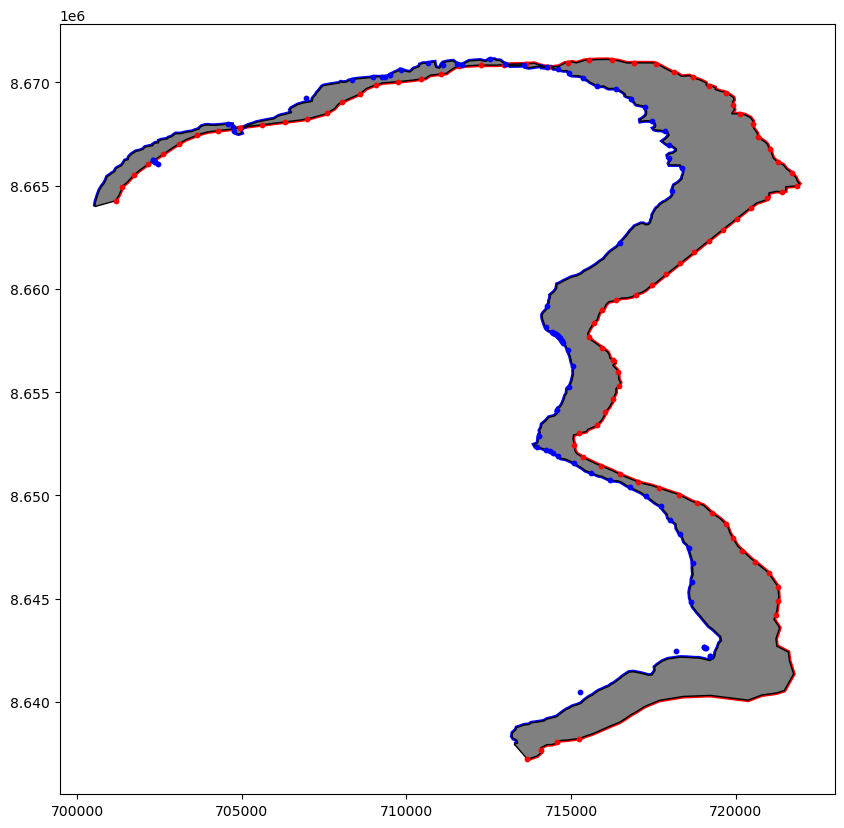

In [15]:
i1, i2 = 1, 2

front1, front2 = fronts_i.iloc[i1].geometry, fronts_i.iloc[i2].geometry
dir1, dir2 = fronts_i.iloc[i1].front_dir, fronts_i.iloc[i2].front_dir
u = np.array([1, 1]) / np.sqrt(2)

## absolute distance
# print("length imbalance :", np.abs(front1.length - front2.length)/np.min([front1.length, front2.length]))
# polygon1 = Polygon(list(front1.coords) + list(front2.coords))
# area1 = polygon1.area
# polygon2 = Polygon(list(front1.coords) + list(front2.coords)[::-1])
# area2 = polygon2.area
# print("area imbalance :", np.abs(area1 - area2)/np.max([area1, area2]))
# d1 = area1/((front1.length + front2.length)/2)
# d2 = area2/((front1.length + front2.length)/2)
# print("distances :", d1, d2)

points_1 = [shapely.Point(coords) for coords in front1.coords]
points_2 = [shapely.Point(coords) for coords in front2.coords]

if shapely.distance(points_1[0], points_2[0]) > shapely.distance(points_1[0], points_2[-1]):
    points_2 = points_2[::-1]
    front2 = shapely.LineString(points_2)
    
polygon = shapely.Polygon(list(front1.coords) + list(front2.coords[::-1]))
area = polygon.area
d = area / ((front1.length + front2.length) / 2)
print("area :", area, "distance :", d)

## direction
# middle of extreme points → not working
# c1 = (np.array(front1.coords)[0] + np.array(front1.coords)[-1])/2
# c2 = (np.array(front2.coords)[0] + np.array(front2.coords)[-1])/2

# centroids → works but a lot of rejections
# c1 = np.array([shapely.centroid(front1).x, shapely.centroid(front1).y])
# c2 = np.array([shapely.centroid(front2).x, shapely.centroid(front2).y])

# center of the font → not working well
# c1 = np.array([front1.interpolate(0.5 * front1.length).x, front1.interpolate(0.5 * front1.length).y])
# c2 = np.array([front2.interpolate(0.5 * front2.length).x, front2.interpolate(0.5 * front2.length).y])

# dot_prod = np.dot(c2-c1, u)#/ np.linalg.norm(c2-c1)
# sgn = np.sign(dot_prod)
# print("dot product :", dot_prod, "sign :", sgn)

# center of the front1 + using flow direction → probably the best solution
points_interp_1 = pd.DataFrame(
    [],
    columns=["points", "x", "y"]
)
points_interp_1.loc[:, "points"] = front1.interpolate(np.linspace(0, front1.length, 100))
points_interp_1.loc[:, ["x", "y"]] = np.stack([np.array([points_interp_1.points.iloc[i].x, points_interp_1.points.iloc[i].y]) for i in range(100)], axis=0)
ll = shapely.MultiLineString([np.stack([points_interp_1.loc[:, ["x", "y"]].iloc[i] - u * 50000, points_interp_1.loc[:, ["x", "y"]].iloc[i] + u * 50000])for i in range(100)])
points_interp_2 = pd.DataFrame(
    [],
    columns=["points", "x", "y"]
)
for i in range(len(points_interp_1)):
    l = ll.geoms[i]
    point_interp_2_i = shapely.intersection(front2, l)
    
    if point_interp_2_i.is_empty:
        points_interp_2.loc[len(points_interp_2), ["points", "x", "y"]] = [None, None, None]
        
    elif isinstance(point_interp_2_i, shapely.Point):
        points_interp_2.loc[len(points_interp_2), ["points", "x", "y"]] = [point_interp_2_i, point_interp_2_i.x, point_interp_2_i.y]
    
    elif isinstance(point_interp_2_i, shapely.MultiPoint):
        point_interp_2_i = np.array([np.array([pt.x, pt.y]) for pt in point_interp_2_i.geoms]).mean(axis=0)
        point_interp_2_i = shapely.Point(point_interp_2_i)
        points_interp_2.loc[len(points_interp_2), ["points", "x", "y"]] = [point_interp_2_i, point_interp_2_i.x, point_interp_2_i.y]

points_interp = pd.concat([points_interp_1, points_interp_2], axis=1)
points_interp.columns = ["points_1", "x1", "y1", "points_2", "x2", "y2"]
points_interp.dropna(inplace=True)

# points_interp
points_interp.loc[:, "x21"] = points_interp.loc[:, "x2"] - points_interp.loc[:, "x1"]
points_interp.loc[:, "y21"] = points_interp.loc[:, "y2"] - points_interp.loc[:, "y1"]
dot_prod = points_interp.loc[:, ["x21", "y21"]].apply(lambda z: z.x21 * u[0] + z.y21 * u[1], axis=1)
points_interp.loc[:, "dot_prod"] = dot_prod
sgn = np.sign(points_interp.dot_prod.mean())

print("distance from dot prod :", dot_prod.mean() , ", direction :", sgn)

## plots
# fig, axs = plt.subplots(ncols=2, figsize=[10, 6])
# shapely.plotting.plot_line(front1, color="red", add_points=False, linewidth=3, ax=axs[0])
# shapely.plotting.plot_line(front2, color="blue", add_points=False, linewidth=3, ax=axs[0])
# shapely.plotting.plot_polygon(polygon1, facecolor="gray", edgecolor="k", add_points=False, ax=axs[0])
# # axs[0].scatter(c1[0], c1[1], color="red")
# # axs[0].scatter(c2[0], c2[1], color="blue")
# # shapely.plotting.plot_points(c1_s, color="red", ax=axs[0])
# # shapely.plotting.plot_points(c2_s, color="blue", ax=axs[0])
# axs[0].scatter(points_interp.x1, points_interp.y1, color="red", s=10, label="front 1")
# axs[0].scatter(points_interp.x2, points_interp.y2, color="blue", s=10, label="front 2")

# shapely.plotting.plot_line(front1, color="red", add_points=False, linewidth=3, ax=axs[1])
# shapely.plotting.plot_line(front2, color="blue", add_points=False, linewidth=3, ax=axs[1])
# shapely.plotting.plot_polygon(polygon2, facecolor="gray", edgecolor="k", add_points=False, ax =axs[1])
# # axs[1].scatter(c1[0], c1[1], color="red")
# # axs[1].scatter(c2[0], c2[1], color="blue")
# # shapely.plotting.plot_points(c1_s, color="red", ax=axs[1])
# # shapely.plotting.plot_points(c2_s, color="blue", ax=axs[1])
# axs[1].scatter(points_interp.x1, points_interp.y1, color="red", s=10, label="front 1")
# axs[1].scatter(points_interp.x2, points_interp.y2, color="blue", s=10, label="front 2")

fig, ax = plt.subplots(figsize=[10, 10])
shapely.plotting.plot_line(front1, color="red", add_points=False, linewidth=3, ax=ax)
shapely.plotting.plot_line(front2, color="blue", add_points=False, linewidth=3, ax=ax)
shapely.plotting.plot_polygon(polygon, facecolor="gray", edgecolor="k", add_points=False, ax=ax)
ax.scatter(points_interp.x1, points_interp.y1, color="red", s=10, label="front 1")
ax.scatter(points_interp.x2, points_interp.y2, color="blue", s=10, label="front 2")

### Definition of general functions to do it

In [ ]:
# def distance_abs(front1, front2):
#     '''
#     Calculates the absolute distance between two fronts, by dividing the area of the polygon by the mean length.
#     If the front lengths are too different (50%), returns None.
#     '''
#     if np.abs(front1.length - front2.length)/np.min([front1.length, front2.length]) >= 0.5:
#         return None
#     else:
#         polygon1 = Polygon(list(front1.coords) + list(front2.coords))
#         area1 = polygon1.area
#         polygon2 = Polygon(list(front1.coords) + list(front2.coords)[::-1])
#         area2 = polygon2.area
#         return 2 * np.min([area1, area2]) / (front1.length + front2.length)
    
# def distance(front1, front2, dir_1, dir_2):
#     '''
#     Calculates the signed distance between two fronts, using flow direction.
#     returns a tuple (distance, error_code):
#     - distance: the signed distance between the fronts, or None if the fronts are too different
#     - error_code: 0 = everything is ok,, 1 = front lengths are too different, 2 = direction is inaccurate 
#     '''
#     assert dir_1 == dir_2, "Fronts must have the same direction" # not necessary for the calculation, just sanitary check.
#     dist_abs = distance_abs(front1, front2)
#     if dist_abs is None:
#         return None, 1
#     else:
#         # transform direction into av vector:
#         if dir_1 == "N":
#             dir_vector = np.array([0, 1])
#         elif dir_1 == "S":
#             dir_vector = np.array([0, -1])
#         elif dir_1 == "E":
#             dir_vector = np.array([1, 0])
#         elif dir_1 == "W":
#             dir_vector = np.array([-1, 0])
#         elif dir_1 == "NE":
#             dir_vector = np.array([1, 1]) / np.sqrt(2)
#         elif dir_1 == "NW":
#             dir_vector = np.array([-1, 1]) / np.sqrt(2)
#         elif dir_1 == "SE":
#             dir_vector = np.array([1, -1]) / np.sqrt(2)
#         elif dir_1 == "SW":
#             dir_vector = np.array([-1, -1]) / np.sqrt(2)
#         else:
#             raise ValueError(f"Unknown direction: {dir_1}")
        
#         # old method with centroids
#         # c1 = np.array([shapely.centroid(front1).x, shapely.centroid(front1).y])
#         # c2 = np.array([shapely.centroid(front2).x, shapely.centroid(front2).y])
        
#         # dot_prod = np.dot(c2-c1, dir_vector)/ np.linalg.norm(c2-c1)
        
#         # if np.abs(dot_prod) < np.sqrt(2)/2:
#         #     return None, 2
#         # else:
#         #     return np.sign(dot_prod) * dist_abs, 0
        
#         c1 = np.array([front1.interpolate(0.5 * front1.length).x, front1.interpolate(0.5 * front1.length).y])
#         l = shapely.LineString(np.stack([c1 - dir_vector * 50000, c1, c1 + dir_vector * 50000]))
#         c2_s = shapely.intersection(front2, l)
        
        
#         if c2_s.is_empty or isinstance(c2_s, shapely.geometry.multipoint.MultiPoint):
#             return None, 2
#         else:
#             c2 = np.array([c2_s.x, c2_s.y])
#             dot_prod = np.dot(c2-c1, dir_vector) #/ np.linalg.norm(c2-c1) # normalisation can be removed to give an extra assessment of the distance.
#             return np.sign(dot_prod) * dist_abs, 0

def distance_abs(front1, front2):
    '''
    Calculates the absolute distance between two fronts, by dividing the area of the polygon by the mean length.
    If the front lengths are too different (50%), returns None.
    '''
    if np.abs(front1.length - front2.length)/np.min([front1.length, front2.length]) >= 0.5:
        return None
    else:
        points_1 = [shapely.Point(coords) for coords in front1.coords]
        points_2 = [shapely.Point(coords) for coords in front2.coords]

        if shapely.distance(points_1[0], points_2[0]) > shapely.distance(points_1[0], points_2[-1]):
            points_2 = points_2[::-1]
            front2 = shapely.LineString(points_2)
            
        polygon = shapely.Polygon(list(front1.coords) + list(front2.coords[::-1]))
        area = polygon.area
        d = area / ((front1.length + front2.length) / 2)
        return 2 * area / (front1.length + front2.length)
    
def distance_sgn(front1, front2, u):
    points_interp_1 = pd.DataFrame(
        [],
        columns=["points", "x", "y"]
    )
    points_interp_1.loc[:, "points"] = front1.interpolate(np.linspace(0, front1.length, 100))
    points_interp_1.loc[:, ["x", "y"]] = np.stack([np.array([points_interp_1.points.iloc[i].x, points_interp_1.points.iloc[i].y]) for i in range(100)], axis=0)
    ll = shapely.MultiLineString([np.stack([points_interp_1.loc[:, ["x", "y"]].iloc[i] - u * 50000, points_interp_1.loc[:, ["x", "y"]].iloc[i] + u * 50000])for i in range(100)])
    points_interp_2 = pd.DataFrame(
        [],
        columns=["points", "x", "y"]
    )
    for i in range(len(points_interp_1)):
        l = ll.geoms[i]
        point_interp_2_i = shapely.intersection(front2, l)
        
        if point_interp_2_i.is_empty:
            points_interp_2.loc[len(points_interp_2), ["points", "x", "y"]] = [None, None, None]
            
        elif isinstance(point_interp_2_i, shapely.Point):
            points_interp_2.loc[len(points_interp_2), ["points", "x", "y"]] = [point_interp_2_i, point_interp_2_i.x, point_interp_2_i.y]
        
        elif isinstance(point_interp_2_i, shapely.MultiPoint):
            point_interp_2_i = np.array([np.array([pt.x, pt.y]) for pt in point_interp_2_i.geoms]).mean(axis=0)
            point_interp_2_i = shapely.Point(point_interp_2_i)
            points_interp_2.loc[len(points_interp_2), ["points", "x", "y"]] = [point_interp_2_i, point_interp_2_i.x, point_interp_2_i.y]

    points_interp = pd.concat([points_interp_1, points_interp_2], axis=1)
    points_interp.columns = ["points_1", "x1", "y1", "points_2", "x2", "y2"]
    points_interp.dropna(inplace=True)
    
    if len(points_interp) == 0:
        return None
    else:
        dot_prod = points_interp.loc[:, ["x1", "y1", "x2", "y2"]].apply(lambda z: (z.x2 - z.x1) * u[0] + (z.y2 - z.y1) * u[1], axis=1)
        sgn = np.sign(dot_prod.mean())
        return sgn

def distance(front1, front2, dir_1, dir_2):
    assert dir_1 == dir_2, "Fronts must have the same direction" # not necessary for the calculation, just sanitary check.
    dist_abs = distance_abs(front1, front2)
    if dist_abs is None:
        return None, 1
    else:
        # transform direction into av vector:
        if dir_1 == "N":
            u = np.array([0, 1])
        elif dir_1 == "S":
            u = np.array([0, -1])
        elif dir_1 == "E":
            u = np.array([1, 0])
        elif dir_1 == "W":
            u = np.array([-1, 0])
        elif dir_1 == "NE":
            u = np.array([1, 1]) / np.sqrt(2)
        elif dir_1 == "NW":
            u = np.array([-1, 1]) / np.sqrt(2)
        elif dir_1 == "SE":
            u = np.array([1, -1]) / np.sqrt(2)
        elif dir_1 == "SW":
            u = np.array([-1, -1]) / np.sqrt(2)
        else:
            raise ValueError(f"Unknown direction: {dir_1}")
        
        sgn = distance_sgn(front1, front2, u)
        
        if sgn is None:
            return None, 2
        else:       
            return sgn * dist_abs, 0

### Uncertainties

KH

Timestamp: 1962-05-16 00:00:00, Mean distance: -9.01 m, Standard deviation: 541.26 m
Timestamp: 1963-08-29 00:00:00, Mean distance: 1.34 m, Standard deviation: 234.62 m
Skipped 59 (2 direction and 57 length) comparisons out of 536.


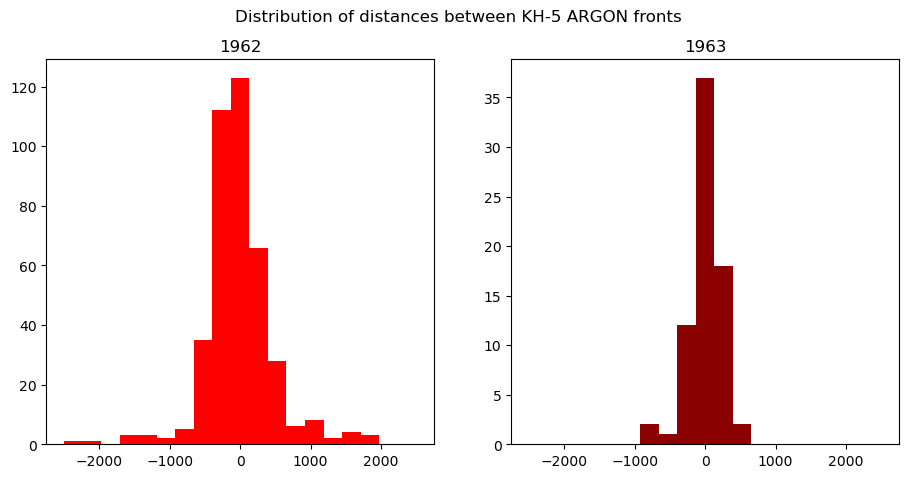

In [41]:
dists = []
skip_count_len = 0
skip_count_dir = 0
total_count = 0
timestamps = [datetime.datetime(1962, 5, 16), datetime.datetime(1963, 8, 29)]
for timestamp in timestamps:
    dists_timestamp = []
    front_ids = kh_fronts.loc[kh_fronts.timestamp == timestamp].front_id.unique()
    for i_front_id, front_id in enumerate(front_ids):
        fronts = kh_fronts.loc[kh_fronts.front_id == front_id].loc[kh_fronts.timestamp == timestamp]
        for k in range(len(fronts.geometry) - 1):
            for l in range(k + 1, len(fronts.geometry)):
                front1 = fronts.geometry.iloc[k]
                front2 = fronts.geometry.iloc[l]
                dir_1 = fronts.front_dir.iloc[k]
                dir_2 = fronts.front_dir.iloc[l]
                dist, e = distance(front1, front2, dir_1, dir_2)
                if dist == np.nan:
                    print(f"Warning: NaN distance for front_id {front_id}, timestamp {timestamp}, indices {k}, {l}")
                if dist is not None:
                    dists_timestamp.append(dist)
                elif e == 1:
                    skip_count_len += 1
                elif e == 2:
                    skip_count_dir += 1
                total_count += 1
    dists.append(dists_timestamp)
        
dists_npy = [np.array(dists_timestamp) for dists_timestamp in dists]
sigma_kh = [dists_npy_timestamp.std() for dists_npy_timestamp in dists_npy]
mean = [dists_npy_timestamp.mean() for dists_npy_timestamp in dists_npy]

for i in range(len(timestamps)):
    print(f"Timestamp: {timestamps[i]}, Mean distance: {mean[i]:.2f} m, Standard deviation: {sigma_kh[i]:.2f} m")

print(f"Skipped {skip_count_len + skip_count_dir} ({skip_count_dir} direction and {skip_count_len} length) comparisons out of {total_count}.")
fig, axs = plt.subplots(ncols=len(timestamps), figsize=(11, 5))
axs[0].hist(dists[0], bins=np.linspace(-2500, 2500, 20), color="red")
axs[0].set_title(timestamps[0].strftime("%Y"))
axs[1].hist(dists[1], bins=np.linspace(-2500, 2500, 20), color="darkred")
axs[1].set_title(timestamps[1].strftime("%Y"))
fig.suptitle("Distribution of distances between KH-5 ARGON fronts")
fig.savefig("images/KH-5_ARGON_fonts_accuracy.png", bbox_inches="tight")

Landsat

Year: 1976, Mean distance: -8.96 m, Standard deviation: 80.70 m
Year: 1978, Mean distance: 16.64 m, Standard deviation: 117.93 m
Skipped 59 (0 direction and 59 length) comparisons out of 337.


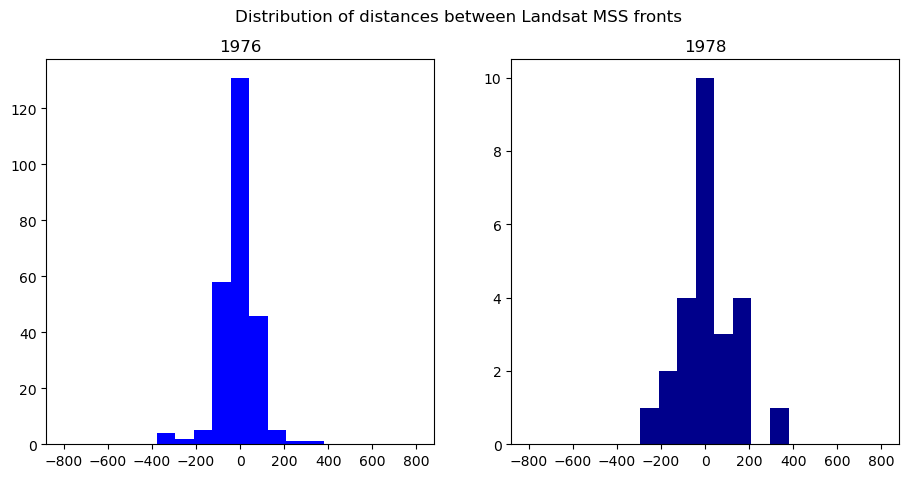

In [43]:
def get_year(timestamp):
    return timestamp.year

dists = []
skip_count_len = 0
skip_count_dir = 0
total_count = 0
years = [1976, 1978]
for year in years:
    dists_year = []
    front_ids = landsat_fronts.loc[landsat_fronts.timestamp.apply(get_year) == year].front_id.unique()
    for front_id in front_ids:
        fronts = landsat_fronts.loc[landsat_fronts.front_id == front_id].loc[landsat_fronts.timestamp.apply(get_year) == year]
        for k in range(len(fronts.geometry) - 1):
            for l in range(k + 1, len(fronts.geometry)):
                front1 = fronts.geometry.iloc[k]
                front2 = fronts.geometry.iloc[l]
                dir_1 = fronts.front_dir.iloc[k]
                dir_2 = fronts.front_dir.iloc[l]
                dist, e = distance(front1, front2, dir_1, dir_2)
                if dist is not None:
                    dists_year.append(dist)
                elif e == 1:
                    skip_count_len += 1
                elif e == 2:
                    skip_count_dir += 1
                total_count += 1
    dists.append(dists_year)
        
dists_npy = [np.array(dists_year) for dists_year in dists]
sigma_landsat = [dists_npy_year.std() for dists_npy_year in dists_npy]
mean = [dists_npy_year.mean() for dists_npy_year in dists_npy]

for i in range(len(years)):
    print(f"Year: {years[i]}, Mean distance: {mean[i]:.2f} m, Standard deviation: {sigma_landsat[i]:.2f} m")

print(f"Skipped {skip_count_len + skip_count_dir} ({skip_count_dir} direction and {skip_count_len} length) comparisons out of {total_count}.")
fig, axs = plt.subplots(ncols=len(years), figsize=(11, 5))
axs[0].hist(dists[0], bins=np.linspace(-800, 800, 20), color="blue")
axs[0].set_title(years[0])
axs[1].hist(dists[1], bins=np.linspace(-800, 800, 20), color="darkblue")
axs[1].set_title(years[1])
fig.suptitle("Distribution of distances between Landsat MSS fronts")
fig.savefig("images/Landsat_MSS_fonts_accuracy.png", bbox_inches="tight")

Recompile uncertainties

In [44]:
years = np.array([1962, 1963, 1976, 1978])
sigmas_prime = np.floor(np.concatenate([sigma_kh, sigma_landsat]))
sigmas = np.floor(sigmas_prime / np.sqrt(2))
print(sigmas_prime, sigmas)

[541. 234.  80. 117.] [382. 165.  56.  82.]


In [45]:
uncertainties = pd.DataFrame(
    [],
    columns=["year_1", "year_2", "sigma_dist", "2_sigma_dist", "3_sigma_dist"]
)

for i in range(len(years) - 1):
    for j in range(i, len(years)):
        uncertainties.loc[len(uncertainties)] = [
            years[i],
            years[j],
            np.sqrt(sigmas[i]**2 + sigmas[j]**2),
            2 * np.sqrt(sigmas[i]**2 + sigmas[j]**2),
            3 * np.sqrt(sigmas[i]**2 + sigmas[j]**2)
        ]
        
uncertainties.loc[:, "years"] = uncertainties.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
uncertainties = uncertainties[["year_1", "year_2", "years", "sigma_dist", "2_sigma_dist", "3_sigma_dist"]]
uncertainties

,year_1,year_2,years,sigma_dist,2_sigma_dist,3_sigma_dist
0,1962.0,1962.0,"(1962.0, 1962.0)",540.229581,1080.459162,1620.688742
1,1962.0,1963.0,"(1962.0, 1963.0)",416.111764,832.223528,1248.335291
2,1962.0,1976.0,"(1962.0, 1976.0)",386.082893,772.165785,1158.248678
3,1962.0,1978.0,"(1962.0, 1978.0)",390.701932,781.403865,1172.105797
4,1963.0,1963.0,"(1963.0, 1963.0)",233.345238,466.690476,700.035713
5,1963.0,1976.0,"(1963.0, 1976.0)",174.244082,348.488163,522.732245
6,1963.0,1978.0,"(1963.0, 1978.0)",184.252544,368.505088,552.757632
7,1976.0,1976.0,"(1976.0, 1976.0)",79.195959,158.391919,237.587878
8,1976.0,1978.0,"(1976.0, 1978.0)",99.297533,198.595065,297.892598


### Results

Calculate distances between every pair of fronts

In [46]:
results = pd.DataFrame(
    [],
    columns = ["front_id", "year_1", "year_2", "distance"]
)
total_count_len = 0
skip_count_dir = 0
total_count = 0
years = [1962, 1963, 1976, 1978]

for front in all_fronts.front_id.unique():
    # compare observations from any year to fronts from any other year, for a specific front.
    for i_year in range(len(years) - 1):
        year = years[i_year]
        fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == year]
        for i_other_year in range(i_year + 1, len(years)):
            other_year = years[i_other_year]
            other_fronts = all_fronts.loc[all_fronts.front_id == front].loc[all_fronts.timestamp.apply(get_year) == other_year]
            
            dists = []
            # compare all the observations between them
            for k in range(len(fronts.geometry)):
                for l in range(len(other_fronts.geometry)):
                    front1 = fronts.geometry.iloc[k]
                    front2 = other_fronts.geometry.iloc[l]
                    dir_1 = fronts.front_dir.iloc[k]
                    dir_2 = other_fronts.front_dir.iloc[l]
                    # print(front) # to identify the fronts that have different flow directions.
                    dist, e = distance(front1, front2, dir_1, dir_2)
                    if dist is not None: # recall: distance returns None if the lengths of the fronts are too different
                        dists.append(dist)
                    elif e == 1:
                        skip_count_len += 1
                    elif e == 2:
                        skip_count_dir += 1
                    total_count += 1
            
            if not dists == []:
                # horrible hack to load an array as a value in a DataFrame
                results_i = pd.DataFrame(
                    [[front, year, other_year, np.array(dists)]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )      
            else: # load None instead of a list of distances
                results_i = pd.DataFrame(
                    [[front, year, other_year, None]],
                    columns=["front_id", "year_1", "year_2", "distance"]
                )
            results = pd.concat([results, results_i])
            
print(f"Skipped {skip_count_len + skip_count_dir} ({skip_count_dir} direction and {skip_count_len} length) comparisons out of {total_count}.")
results.reset_index(drop=True, inplace=True)
results = results.dropna().reset_index(drop=True)
results

Skipped 556 (8 direction and 548 length) comparisons out of 2029.


,front_id,year_1,year_2,distance
0,2,1962,1963,"[-79.48402579080955, -603.780206891322, -823.4..."
1,2,1962,1976,"[-400.01519757875695, -461.60260977397235, -44..."
2,2,1962,1978,"[-564.3538386904038, -1109.0978650814443]"
3,2,1963,1976,"[-300.9716348393031, -392.455685340897, -386.9..."
4,2,1963,1978,[-505.13812309827387]
...,...,...,...,...
433,87,1976,1978,[-91.97451945462406]
434,82,1976,1978,[-153.44472935472436]
435,66,1976,1978,[-72.56704667293884]
436,72,1976,1978,[-33.72669053388882]


When several measures are available, try to identify a distribution pattern :

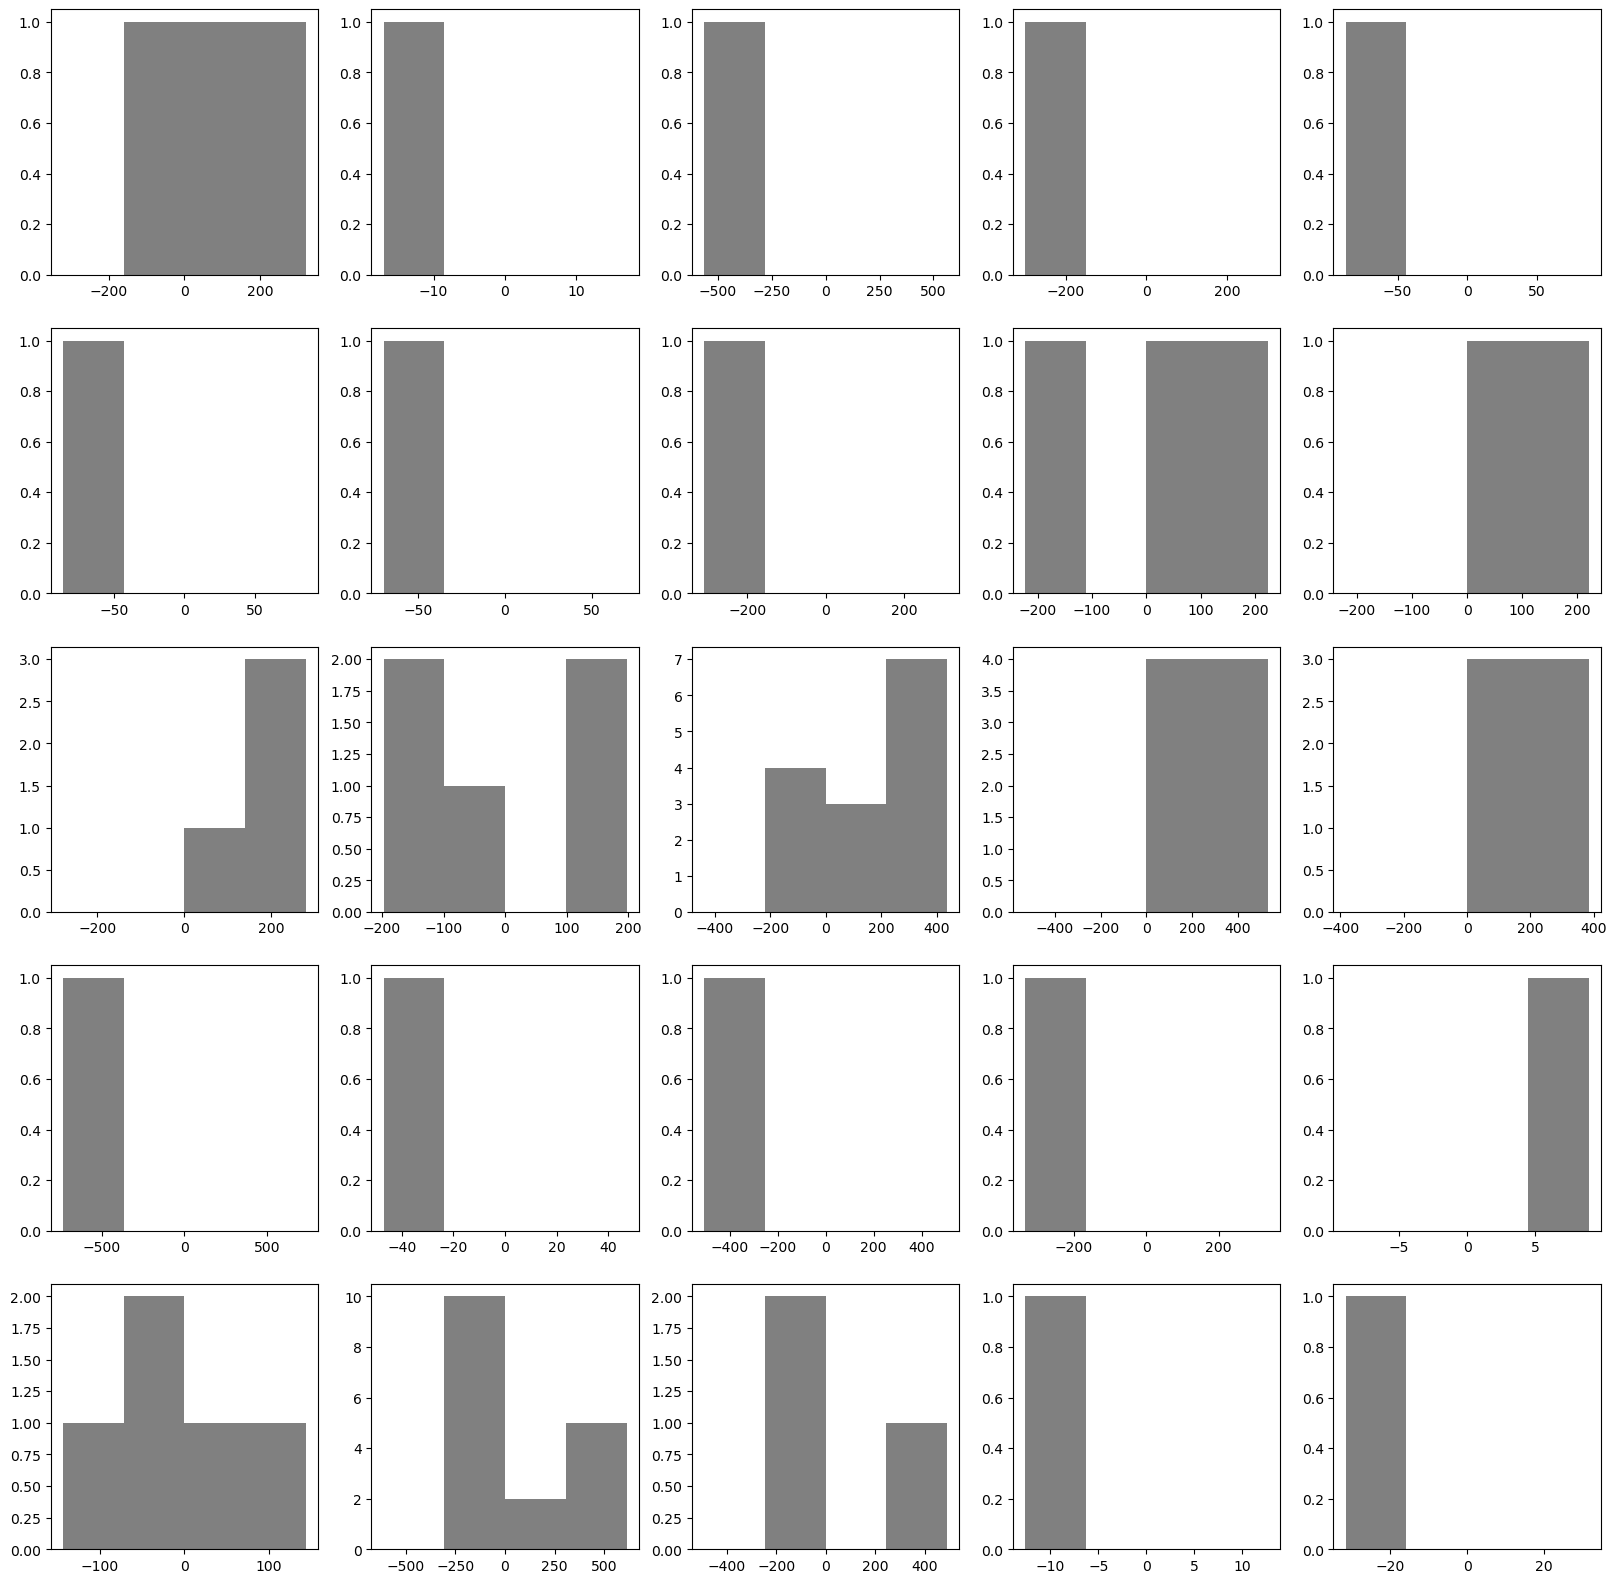

In [47]:
fig, axs = plt.subplots(ncols=5, nrows=5, figsize=[20, 20])
c = 0
for i in range(len(results)):
    if len(results.distance[i]) > 1:
        if c < 25:
            axs[c//5, c%5].hist(results.distance[i], bins=np.linspace(-np.abs(results.distance[i].max()), np.abs(results.distance[i].max()), 5), color="gray")
        c += 1

**Conclusion :** No pattern identified → each distances distribution is approximated by its mean value and associated to the corresponding uncertainty.

In [48]:
results.loc[:, "mean_distance"] = results.distance.apply(lambda x: np.array(x).mean())
results.loc[:, "uncertainty"] = results.loc[:, ["year_1", "year_2"]].apply(lambda x: uncertainties.loc[(uncertainties.year_1 == x.iloc[0]) & (uncertainties.year_2 == x.iloc[1]), "2_sigma_dist"].values[0], axis=1)

# not necessary but easier to control results : put the years in a single column. 
results.loc[:, "years"] = results.loc[:, ["year_1", "year_2"]].apply(lambda x: (x.iloc[0], x.iloc[1]), axis=1)
results = results[["front_id", "year_1", "year_2", "years", "distance", "mean_distance", "uncertainty"]]

results

,front_id,year_1,year_2,years,distance,mean_distance,uncertainty
0,2,1962,1963,"(1962, 1963)","[-79.48402579080955, -603.780206891322, -823.4...",-224.208494,832.223528
1,2,1962,1976,"(1962, 1976)","[-400.01519757875695, -461.60260977397235, -44...",-630.599571,772.165785
2,2,1962,1978,"(1962, 1978)","[-564.3538386904038, -1109.0978650814443]",-836.725852,781.403865
3,2,1963,1976,"(1963, 1976)","[-300.9716348393031, -392.455685340897, -386.9...",-369.829291,348.488163
4,2,1963,1978,"(1963, 1978)",[-505.13812309827387],-505.138123,368.505088
...,...,...,...,...,...,...,...
433,87,1976,1978,"(1976, 1978)",[-91.97451945462406],-91.974519,198.595065
434,82,1976,1978,"(1976, 1978)",[-153.44472935472436],-153.444729,198.595065
435,66,1976,1978,"(1976, 1978)",[-72.56704667293884],-72.567047,198.595065
436,72,1976,1978,"(1976, 1978)",[-33.72669053388882],-33.726691,198.595065


In [49]:
# horrible way to plot a summary of the results, but I could not find better.
results_overview = pd.DataFrame(
    [],
    columns=["years", "uncertainty", "count"]
)
results_overview.loc[:, "years"] = results.years.unique()
results_overview.loc[:, "uncertainty"] = results.uncertainty.unique()
results_overview.loc[:, "count"] = results.years.value_counts().values
results_overview

,years,uncertainty,count
0,"(1962, 1963)",832.223528,101
1,"(1962, 1976)",772.165785,94
2,"(1962, 1978)",781.403865,70
3,"(1963, 1976)",348.488163,63
4,"(1963, 1978)",368.505088,61
5,"(1976, 1978)",198.595065,49


Compare results tu uncertainties to identify trustworthy examples

61 -24.485350589361772 210.0934198013083
101 -148.1178817001071 572.2627861049366
70 -119.02422794628671 710.7524707503843
63 -234.8601061121325 642.4225181531867
49 -214.81038674183898 730.8801440754099
94 -56.1974029056221 149.02993517388848


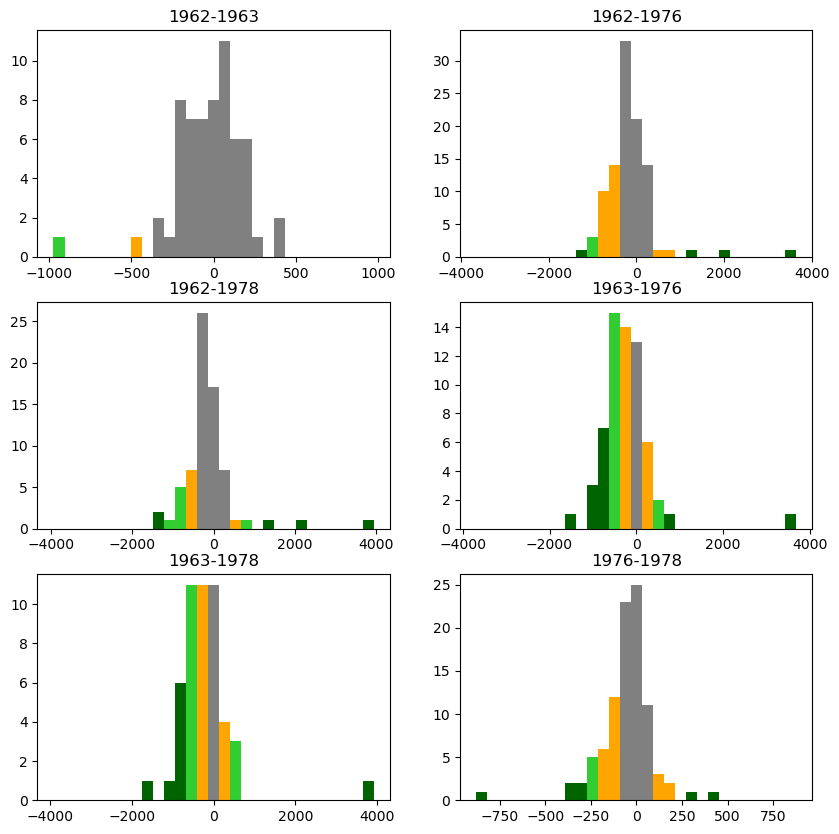

In [50]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10, 10))

color_sigma = "orange"
color_2_sigma = "limegreen"
color_3_sigma = "darkgreen"
nbins = 30

years = (1962, 1963)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[0, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2  # shift bins to the center
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 0].set_title(f"{years[0]}-{years[1]}")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1976)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[0, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[0, 1].set_title(f"{years[0]}-{years[1]}")
print(d.shape[0], d.mean(), d.std())
        
years = (1962, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[1, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 0].set_title(f"{years[0]}-{years[1]}")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1976)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[1, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[1, 1].set_title(f"{years[0]}-{years[1]}")
print(d.shape[0], d.mean(), d.std())
        
years = (1963, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[2, 0].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 0].set_title(f"{years[0]}-{years[1]}")
print(d.shape[0], d.mean(), d.std())
        
years = (1976, 1978)
d = results.loc[results.years == years].mean_distance
N, bins, patches = axs[2, 1].hist(d, color="gray", bins=np.linspace(-np.abs(d).max(), np.abs(d).max(), nbins))
sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
bins = np.array(bins) + (bins[1] - bins[0])/2
for i in range(len(patches)):
    if np.abs(bins[i]) >= sigma:
        patches[i].set_facecolor(color_sigma)
    if np.abs(bins[i]) >= 2 * sigma:
        patches[i].set_facecolor(color_2_sigma)
    if np.abs(bins[i]) >= 3 * sigma:
        patches[i].set_facecolor(color_3_sigma)
axs[2, 1].set_title(f"{years[0]}-{years[1]}")
print(d.shape[0], d.mean(), d.std())
fig.savefig("images/results_distances_distributions.png", bbox_inches="tight")

Split trustworthy surges and retreats in separate datasets

In [51]:
# list of surges and retreats

surges = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

retreats = pd.DataFrame(
    [],
    columns=["front_id", "years", "mean_distance", "uncertainty"]
)

for years in [(1962, 1963), (1962, 1976), (1962, 1978), (1963, 1976), (1963, 1978), (1976, 1978)]:
    # print("years :", years)
    sigma = uncertainties.loc[uncertainties.years == years]["sigma_dist"].values[0]
    res = results.where(results.loc[results.years == years, "mean_distance"].apply(lambda x: np.abs(x) >= 2 * sigma)).dropna().loc[:, ["front_id", "years", "mean_distance", "uncertainty"]]
    # print(res)
    surges_1 = res.where(res.mean_distance.apply(lambda x: x >= 0)).dropna()
    retreats_1 = res.where(res.mean_distance.apply(lambda x: x < 0)).dropna()
    if not surges_1.empty:
        surges = pd.concat([surges, surges_1])
    if not retreats_1.empty:
        retreats = pd.concat([retreats, retreats_1])
        
surges

C:\Users\loris\AppData\Local\Temp\ipykernel_23420\2778544960.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  retreats = pd.concat([retreats, retreats_1])
C:\Users\loris\AppData\Local\Temp\ipykernel_23420\2778544960.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  surges = pd.concat([surges, surges_1])


,front_id,years,mean_distance,uncertainty
291,122,"(1962, 1976)",3652.623886,772.165785
347,121,"(1962, 1976)",1962.144474,772.165785
396,123,"(1962, 1976)",1312.976490,772.165785
288,120,"(1962, 1978)",883.417455,781.403865
292,122,"(1962, 1978)",3943.133563,781.403865
348,121,"(1962, 1978)",2084.629828,781.403865
397,123,"(1962, 1978)",1280.833637,781.403865
14,26,"(1963, 1976)",350.129044,348.488163
128,56,"(1963, 1976)",719.102820,348.488163
139,92,"(1963, 1976)",473.282988,348.488163


In [52]:
retreats

,front_id,years,mean_distance,uncertainty
149,105,"(1962, 1963)",-972.737134,832.223528
7,4,"(1962, 1976)",-924.789543,772.165785
54,37,"(1962, 1976)",-1211.339623,772.165785
114,54,"(1962, 1976)",-857.949856,772.165785
150,105,"(1962, 1976)",-908.809635,772.165785
...,...,...,...,...
409,73,"(1976, 1978)",-208.357850,198.595065
413,62,"(1976, 1978)",-252.212812,198.595065
415,61,"(1976, 1978)",-285.570105,198.595065
418,60,"(1976, 1978)",-247.863788,198.595065


In [ ]:
# list of all fronts that either surged or retreated with >95% accuracy
len(surges.front_id.unique()), surges.front_id.unique(), len(retreats.front_id.unique()), retreats.front_id.unique()

(10,
 array([122, 121, 123, 120, 26, 56, 92, 91, 93, 165], dtype=object),
 47,
 array([105, 4, 37, 54, 144, 42, 109, 2, 154, 28, 29, 38, 40, 41, 50, 51,
        52, 53, 58, 59, 95, 180, 111, 141, 161, 139, 140, 178, 142, 160,
        106, 32, 33, 49, 108, 113, 116, 136, 43, 93, 76, 74, 73, 62, 61,
        60, 89], dtype=object))

**Conclusion :**
- The method seem to work in general
- There is (apparently) one bad example of detected surge

**To Do :**
- Re-check all cases
- Build a dataset of when the surges happened
- Compare with another method (e.g. box method).